In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
import functions.plotting as NNplt
from functions.rnn_cryptic import generate_sequences, convert_seq2inputs, pad_seqs_2step, calculate_output

In [16]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]


def train(sequence,label,model,optimizer,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()


def run(model, train_data, epochs):

    model.train()
    loss_history = []
    for epoch in range(epochs):
        lossTotal = 0
        for x,y in train_data:
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history.append(lossTotal)

    print(f'loss: {round(lossTotal,1)} ')
    return loss_history

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        if epoch%100 == 0:
            print('epoch: ', epoch)
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
            if (epoch%100 == 2):
                if i%50 == 0:
                    if verbose:
                        print('\n################\nepoch: ',epoch, '\n################\n')
                        print('output =. ' , output.detach().numpy())
                        print('label =. ' , y.detach().numpy())
                        test_acc(model, test_data, hidden_size, verbose = True)
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    print(f'loss: {round(lossTotal,1)} ')
    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

def run_sim(i, train_trials, test_trials):
    print('########## rep', i, '#########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials, test_trials, epochs)
    return loss1, acc1, model

def run_sims(i, train_trials, test_trials):
    print('########## rep', i, '#########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials[0], test_trials, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, train_trials[1], test_trials, epochs)
    losses = np.vstack([loss1,loss2])
    accs = np.vstack([acc1,acc2])

    return losses, accs, model

def seq_acc(model, testset, hidden_size, rep = 10, verbose = False):
    
    train_inputs = convert_seq2inputs(testset, num_classes=num_classes, seq_len=5)
    testdata = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
    model.eval()
    trials = []
    accs = []
    for _ in range(rep):
        for j, (x,y) in enumerate(testdata):
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct = sum(torch.round(y[i]) == torch.round(y_hat)).item() 
                accs.append(float(correct))
                curr_trial = testset[j*len(x)+i].copy()
                trials.append([x for x in curr_trial if x!= ('X', 'X')])
#                 trials.append(curr_trial)
    
    df = pd.DataFrame({'trial':trials, 'acc':accs})
    df['trial'] = df['trial'].apply(str)
    df = df.groupby(['trial']).mean()
           
    return df 

# ----------
# plotting
# ----------

def plotNNs(loss_arrays, acc_arrays, labels, colors, title, shift = 0):

    fig, axs = plt.subplots(2, 1)
    loss_cols = ['blue', 'darkblue', 'black']
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[0].plot(x, mn, label = 'loss', color = loss_cols[i])
        axs[0].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = loss_cols[i])
    
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend()
    
    for i, arr in enumerate(acc_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[1].plot(x, mn, label = labels[i], color = colors[i])
        axs[1].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()

    fig.suptitle(title, fontsize=14)

In [3]:
# params

num_classes = 14
batchsize=1
# specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.001


In [9]:

def exp2(p, trainseqs, testseqs):
    t1 = time.time()
    
    for val in trainseqs:
            if val in testseqs:
                testseqs.remove(val)

    padtrain = p + pad_seqs_2step(trainseqs)
    train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    padtest = pad_seqs_2step(testseqs)
    test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
    
    # run
    t1 = time.time()
    num_sims = 8
    epochs = 500
    res = Parallel(n_jobs = -1)(delayed(run_sim)(i, trainset, [trainset, testset]) for i in range(num_sims))

    # format results
    losses = np.hstack([r[0] for r in res])
    acc_train = np.array([r[1][:,0] for r in res]).T
    acc_test = np.array([r[1][:,1] for r in res]).T
    models = [r[2] for r in res]

    # calculate test accuracy on each trial type
    dfs=[]
    for mod in models:
        dfs.append(seq_acc(mod, padtest, hidden_size, rep = 100, verbose = False))
    df = pd.concat(dfs, axis=1)
    print(df.apply(np.mean, axis=1).sort_values(ascending = False))  
    
    # plot
    plotNNs([losses], [acc_train, acc_test], ['train', 'test'], ['red', 'green'], '')
    
    t2 = time.time()
    print('time: ', (t2-t1)/60)
    return losses, acc_train, acc_test, dfs, models

# Multiple ops

trial
['F', ('+', 'B'), 7]     1.0000
['F', ('+', 'A'), 6]     1.0000
['F', ('+', 'D'), 11]    1.0000
['F', ('+', 'C'), 9]     0.9375
['F', ('+', 'E'), 5]     0.8750
['F', ('-', 'D'), -3]    0.7500
['F', ('-', 'B'), 1]     0.7500
['F', ('-', 'E'), 3]     0.7500
['F', ('-', 'C'), -1]    0.6875
['F', ('-', 'A'), 2]     0.6875
['A', ('-', 'F'), -2]    0.6250
['B', ('-', 'F'), -1]    0.6250
['E', ('-', 'F'), -3]    0.6250
['D', ('-', 'F'), 3]     0.5625
['C', ('-', 'F'), 1]     0.5625
['E', ('+', 'F'), 5]     0.5000
['D', ('+', 'F'), 11]    0.5000
['C', ('+', 'F'), 9]     0.5000
['A', ('+', 'F'), 6]     0.4375
['F', ('+', 'F'), 8]     0.4375
['B', ('+', 'F'), 7]     0.4375
['F', ('-', 'F'), 0]     0.4375
dtype: float64
time:  10.302771870295206


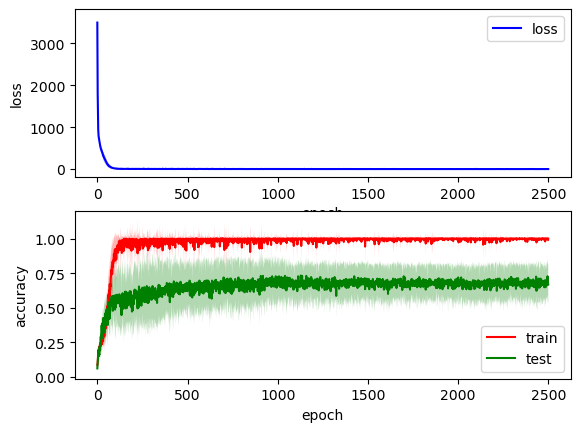

########## rep 0 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
loss: 0.6 
########## rep 5 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
loss: 0.5 
########## rep 2 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  21

In [108]:
#exp1 - 5 train inps ########## TEST: F
epochs = 2500
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4]
    ]

trainseqs = generate_sequences(['+','-'], ['A','B','C', 'D', 'E'], len_seq = 1, init_values = ['A','B', 'C',  'D', 'E'])
testseqs = generate_sequences(['+','-'], ['A','B','C', 'D', 'E', 'F'], len_seq = 1, init_values = ['A','B','C', 'D', 'E', 'F'])

res2ops = exp1(p, trainseqs, testseqs)


trial
['C', ('+', 'D'), 12]    0.9375
['C', ('+', 'A'), 7]     0.8750
['C', ('+', 'B'), 8]     0.8750
['C', ('+', 'E'), 6]     0.8750
['C', ('+', 'F'), 9]     0.8750
['C', ('-', 'E'), 4]     0.8125
['C', ('+', 'C'), 10]    0.8125
['C', ('-', 'A'), 3]     0.8125
['C', ('-', 'B'), 2]     0.7500
['E', ('+', 'C'), 6]     0.7500
['D', ('+', 'C'), 12]    0.7500
['C', ('-', 'D'), -2]    0.7500
['F', ('+', 'C'), 9]     0.6875
['C', ('-', 'F'), 1]     0.6875
['A', ('+', 'C'), 7]     0.6875
['B', ('+', 'C'), 8]     0.6875
['B', ('-', 'C'), -2]    0.5000
['E', ('-', 'C'), -4]    0.5000
['F', ('-', 'C'), -1]    0.5000
['A', ('-', 'C'), -3]    0.4375
['C', ('-', 'C'), 0]     0.3750
['D', ('-', 'C'), 2]     0.3750
dtype: float64
time:  3.3510963479677836


NameError: name 'test_outs' is not defined

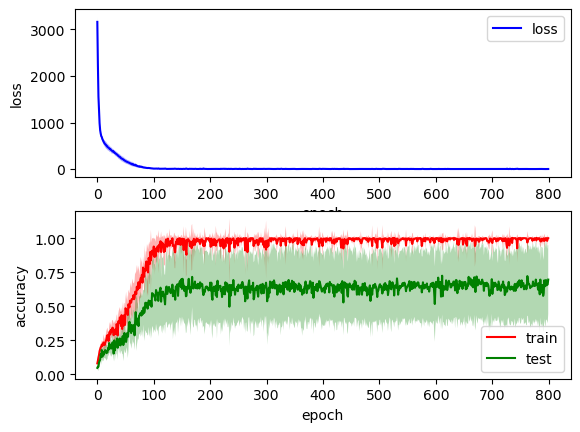

In [6]:
#exp2 - test C
epochs = 2500
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4]
    ]

trainseqs = generate_sequences(['+','-'], ['A','B','F', 'D', 'E'], len_seq = 1, init_values = ['A','B', 'F',  'D', 'E'])
testseqs = generate_sequences(['+','-'], ['A','B','C', 'D', 'E', 'F'], len_seq = 1, init_values = ['A','B','C', 'D', 'E', 'F'])

res2ops2 = exp2(p, trainseqs, testseqs)


trial
['D', ('+', 'H'), 18]    0.8125
['D', ('+', 'G'), 16]    0.8125
['D', ('-', 'E'), 6]     0.6875
['D', ('+', 'E'), 8]     0.6875
['D', ('+', 'C'), 12]    0.6875
['D', ('+', 'B'), 10]    0.6250
['D', ('-', 'A'), 5]     0.6250
['D', ('-', 'B'), 4]     0.6250
['D', ('+', 'A'), 9]     0.6250
['D', ('+', 'F'), 11]    0.5625
['D', ('-', 'H'), -4]    0.5000
['D', ('-', 'G'), -2]    0.5000
['D', ('-', 'F'), 3]     0.4375
['D', ('-', 'C'), 2]     0.4375
['F', ('+', 'D'), 11]    0.3125
['E', ('-', 'D'), -6]    0.2500
['G', ('+', 'D'), 16]    0.2500
['H', ('+', 'D'), 18]    0.2500
['E', ('+', 'D'), 8]     0.2500
['A', ('+', 'D'), 9]     0.2500
['D', ('+', 'D'), 14]    0.2500
['C', ('+', 'D'), 12]    0.2500
['B', ('+', 'D'), 10]    0.2500
['D', ('-', 'D'), 0]     0.1875
['C', ('-', 'D'), -2]    0.1875
['F', ('-', 'D'), -3]    0.1875
['B', ('-', 'D'), -4]    0.1875
['A', ('-', 'D'), -5]    0.1250
['G', ('-', 'D'), 2]     0.1250
['H', ('-', 'D'), 4]     0.1250
dtype: float64
time:  10.102143283

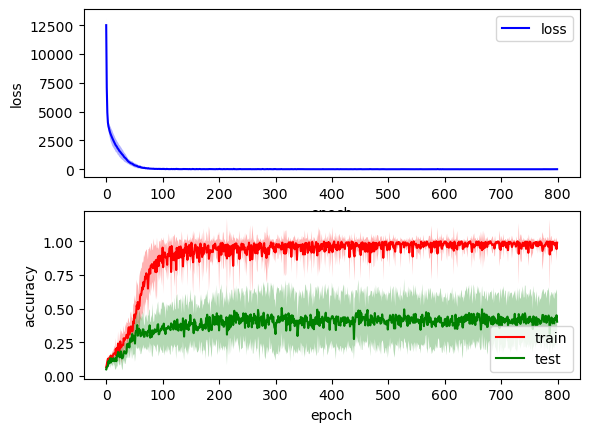

########## rep 1 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
loss: 6.1 
########## rep 7 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
loss: 2.3 
########## rep 3 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
loss: 3.1 
########## rep 6 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
loss: 7.4 
########## rep 5 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
loss: 4.3 
########## rep 4 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
loss: 5.7 
########## rep 0 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
loss: 16.5 
########## rep 2 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
ep

In [15]:
#exp2 - test D
epochs = 800
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4],\
     ['G', ('X','X'), ('X','X'), 9],\
     ['H', ('X','X'), ('X','X'), 11]
    ]

trainseqs = generate_sequences(['+','-'], ['A','B','C', 'E', 'F', 'G', 'H'], len_seq = 1, init_values = ['A','B','C', 'E', 'F', 'G', 'H'])
testseqs = generate_sequences(['+','-'], ['A','B','C', 'D', 'E', 'F', 'G', 'H'], len_seq = 1, init_values = ['A','B','C', 'D', 'E', 'F', 'G', 'H'])

res2ops2 = exp2(p, trainseqs, testseqs)


trial
['D', ('-', 'A'), 5]     0.9375
['D', ('-', 'B'), 4]     0.9375
['D', ('-', 'E'), 6]     0.9375
['D', ('-', 'F'), 3]     0.8750
['D', ('-', 'C'), 2]     0.8125
['D', ('-', 'G'), -2]    0.8125
['D', ('-', 'H'), -4]    0.6875
['D', ('-', 'D'), 0]     0.4375
['F', ('-', 'D'), -3]    0.3750
['A', ('-', 'D'), -5]    0.3125
['B', ('-', 'D'), -4]    0.3125
['C', ('-', 'D'), -2]    0.2500
['E', ('-', 'D'), -6]    0.2500
['G', ('-', 'D'), 2]     0.1875
['H', ('-', 'D'), 4]     0.1875
dtype: float64
time:  3.3089956641197205


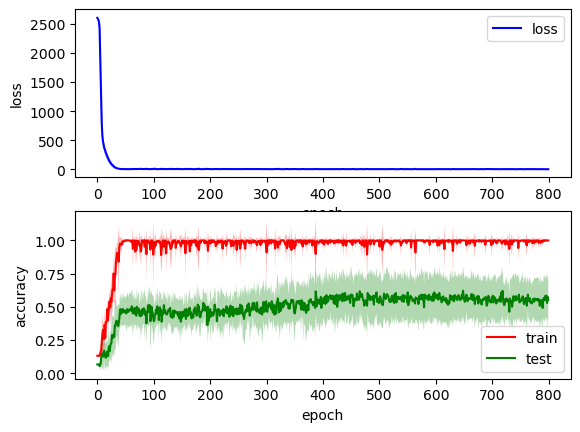

########## rep 1 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
loss: 0.6 
########## rep 3 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
loss: 1.2 
########## rep 4 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
loss: 1.0 
########## rep 0 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
loss: 1.1 
########## rep 5 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
loss: 0.3 
########## rep 7 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
loss: 0.4 
########## rep 6 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
loss: 2.6 
########## rep 2 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epo

In [17]:
#exp3 - test minus
epochs = 800
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4],\
     ['G', ('X','X'), ('X','X'), 9],\
     ['H', ('X','X'), ('X','X'), 11]
    ]

trainseqs = generate_sequences(['-'], ['A','B','C', 'E', 'F', 'G', 'H'], len_seq = 1, init_values = ['A','B','C', 'E', 'F', 'G', 'H'])
testseqs = generate_sequences(['-'], ['A','B','C', 'D', 'E', 'F', 'G', 'H'], len_seq = 1, init_values = ['A','B','C', 'D', 'E', 'F', 'G', 'H'])

res2ops2 = exp2(p, trainseqs, testseqs)


trial
['A', ('+', 'B'), 5]     0.0
['A', ('+', 'C'), 7]     0.0
['A', ('-', 'A'), 0]     0.0
['A', ('-', 'D'), -5]    0.0
['B', ('+', 'B'), 6]     0.0
['B', ('+', 'C'), 8]     0.0
['B', ('-', 'A'), 1]     0.0
['B', ('-', 'D'), -4]    0.0
['C', ('+', 'B'), 8]     0.0
['C', ('+', 'C'), 10]    0.0
['C', ('-', 'A'), 3]     0.0
['C', ('-', 'D'), -2]    0.0
['D', ('+', 'B'), 10]    0.0
['D', ('+', 'C'), 12]    0.0
['D', ('-', 'A'), 5]     0.0
['D', ('-', 'D'), 0]     0.0
dtype: float64
time:  2.3462640841801963


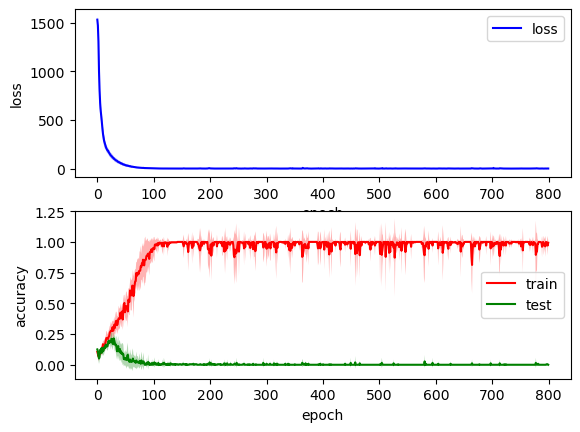

########## rep 3 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
loss: 0.1 
########## rep 5 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
loss: 0.0 
########## rep 4 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
loss: 0.3 
########## rep 6 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
loss: 0.3 
########## rep 1 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
loss: 0.2 
########## rep 0 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
loss: 0.1 
########## rep 2 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
loss: 4.3 
########## rep 7 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epo

In [14]:
#train 2 on + and 2 on -, then switch
# exp 3 : train half on +, half on -. Then switch


p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4]
    ]

trainseqs_add = generate_sequences(['+'], ['A','D'], len_seq = 1, init_values = ['A','B','C', 'D'])
trainseqs_sub = generate_sequences(['-'], ['B','C'], len_seq = 1, init_values = ['A','B','C', 'D'])

trainseqs = trainseqs_add + trainseqs_sub
testseqs = generate_sequences(['+','-'], ['A','B','C', 'D'], len_seq = 1, init_values = ['A','B','C', 'D'])

res2ops3 = exp2(p, trainseqs, testseqs)
